In [1]:
import sys, os, time, shutil, random
from pathlib import Path
# _cwd = os.getcwd()
# os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
# import timm
torch.set_printoptions(linewidth=300, sci_mode=False)
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

# fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets


# from src import sample_full_interventions, response_mat, factor_reponses
# from src.responses import sample_full_interventions

# fig.initialize('sae')
# from omnifig.projects import sae
# import networkx as nx

# # from src import sample_full_interventions, response_mat, factor_reponses
# dataset = None
# src = None

import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP
distinct_colors = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",]
rank = 0
world_size = 1
init_method="file:///C:/Users/anwan/Documents/tmp/env"
# dist.init_process_group(
#    "gloo",
#    rank=rank,
#    init_method=init_method,
#    world_size=world_size)

from model import AutoEncoder
import utils
import datasets

2022-05-04 20:11:38.841100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-05-04 20:11:38.841115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
imgroot = Path('figures')
imgroot.mkdir(exist_ok=True)

In [3]:
dname = 'celeba_64'
dname = 'mnist'
# dname = 'cifar10'

In [4]:
root = Path('checkpoints')
ds_ckpts = list(root.glob('*'))
ds_ckpts

[PosixPath('checkpoints/celeba_64'),
 PosixPath('checkpoints/cifar10'),
 PosixPath('checkpoints/mnist'),
 PosixPath('checkpoints/celeba_64-20220119T083217Z-001.zip'),
 PosixPath('checkpoints/cifar10-20220119T083215Z-002.zip'),
 PosixPath('checkpoints/mnist-20220119T083212Z-001.zip')]

In [5]:
path = random.choice(ds_ckpts)
# path = root / 'mnist'
path = root / dname
if dname == 'cifar10':
    path = path / 'qualitative'
path

PosixPath('checkpoints/mnist')

In [6]:
ckpt = torch.load(path/'checkpoint.pt', map_location='cpu')

# checkpoint = torch.load(eval_args.checkpoint, map_location='cpu')
args = ckpt['args']
if not hasattr(args, 'ada_groups'):
    args.ada_groups = False
if not hasattr(args, 'min_groups_per_scale'):
    args.min_groups_per_scale = 1
if not hasattr(args, 'num_mixture_dec'):
    args.num_mixture_dec = 10
# if eval_args.batch_size > 0:
#     args.batch_size = eval_args.batch_size
arch_instance = utils.get_arch_cells(args.arch_instance)

In [7]:
model = AutoEncoder(args, None, arch_instance)
model.load_state_dict(ckpt['state_dict'], strict=False);
model = model.cuda();

len log norm: 183
len bn: 128


In [8]:
model.eval();

In [9]:
# model.train();

In [10]:
def set_bn(model, bn_eval_mode, num_samples=1, t=1.0, iter=100):
    if bn_eval_mode:
        model.eval()
    else:
        model.train()
        with autocast():
            for i in range(iter):
                if i % 10 == 0:
                    print('setting BN statistics iter %d out of %d' % (i+1, iter))
                model.sample(num_samples, t)
        model.eval()

In [11]:
temperature = 0.7
bn_eval_mode = True

In [27]:
os.environ['OMNILEARN_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data/'

'/is/ei/fleeb/workspace/local_data/'

In [ ]:
os.environ['OMNILEARN_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data/'

In [12]:
# with torch.no_grad():
# #     set_bn(model, bn_eval_mode, num_samples=36, t=temperature, iter=500)
#     x = model.sample(24, temperature)
#     output = model.decoder_output(x)
#     output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
#                         else output.sample()
# # output_img.shape
# util.plot_imgs(output_img);

In [42]:
from omnibelt import unspecified_argument

In [71]:
_global_eps_table = None
def encode(x, t=1., prior=False, distr=True, eps_table=unspecified_argument, **kwargs):
    if eps_table is unspecified_argument:
        eps_table = _global_eps_table
    with torch.no_grad():
        x = x.cuda()
        return model.encode(x, t=t, distr=distr, prior=prior,eps_table=eps_table,  **kwargs)

def decode(all_q, t=1., eps_table=unspecified_argument, **kwargs):
    if eps_table is unspecified_argument:
        eps_table = _global_eps_table
    with torch.no_grad():
#         all_q = [q.cuda() for q in all_q]
        out = model.decode(all_q, t=t,eps_table=eps_table,  **kwargs)
        return to_img(out).cpu()

def to_img(logits):
    with torch.no_grad():
        img = model.decoder_output(logits)
        img = img.mean if isinstance(img, torch.distributions.bernoulli.Bernoulli) \
                            else img.sample()
    return img.cpu()

def enc(x, prior=False, distr=False, **kwargs):
    out = encode(x, prior=prior, distr=distr, **kwargs)
    if prior:
        return out[0][0], out[1][0]
    return out[0]
def dec(q, **kwargs):
    return decode([q], **kwargs)

In [14]:
if dname == 'mnist':
    bsnum = 24
    dataset = fig.quick_run('load-data', name='mnist', batch_size=bsnum, seed=11)
elif dname == 'cifar10':
    bsnum = 24
    dataset = fig.quick_run('load-data', name='cifar10', batch_size=bsnum, seed=11)
elif dname == 'celeba_64':
    bsnum = 12
    dataset = fig.quick_run('load-data', name='celeba', batch_size=bsnum, seed=11, size=64, **{'_dataset_mod': 'interpolated'})
else:
    assert False
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 24
|  > shuffle: True (by default)
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > wrappers: [] (by default)
|  > mode-wrappers: {} (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > default-mode --> mode: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'mnist'
|  > _dataset_mod: [] (by default)
|  > mode-aliases: {} (by default)
|  > seed: 11
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 11
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/mnist)
|  >  > dataroot: None (by default)
|  >  > mode: 'train'
|  >  > download: False (by default)
|  >  > train: True (by default)
|  >  > resiz

60000

In [15]:
batch = dataset.get_batch()
X, *other = batch
X.shape

torch.Size([24, 1, 32, 32])

In [16]:
# util.plot_imgs(X);

<IPython.core.display.Javascript object>


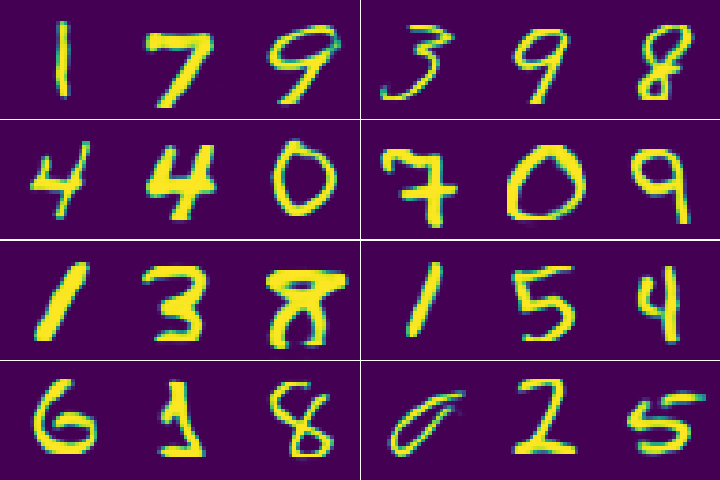

In [79]:
zs, ps = encode(X, distr=False, prior=True, eps_table=None)
def gen_eps_table(N, t=1., expand=True, gen=None):
    if not isinstance(N, int):
        N = N.shape[0]
    if expand:
        return [torch.randn(1, *z.shape[1:], generator=gen).mul(t).expand(N, *z.shape[1:]).to(z) for z in zs]
    return [torch.randn(N,*z.shape[1:], generator=gen).mul(t).to(z) for z in zs]
rec = decode(zs)
util.plot_imgs(rec);

<IPython.core.display.Javascript object>


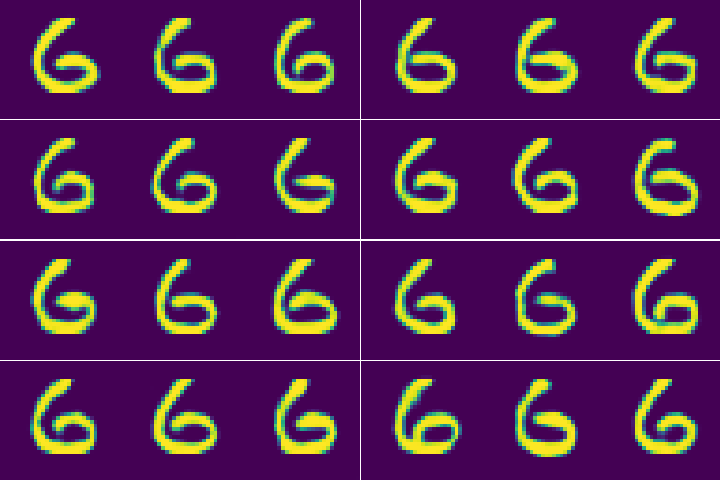

In [80]:
Xc = X[[torch.randint(len(X), size=()).item()]].expand(*X.shape)
util.plot_imgs(decode(encode(Xc, distr=True, eps_table=None), eps_table=None));

In [81]:
_global_eps_table = gen_eps_table(1, t=1, gen=torch.Generator().manual_seed(101))

In [19]:
# zis = zs.copy()
# zis = zis[:5]
# dis = decode(zis, t=0)
# util.plot_imgs(dis);

In [20]:
# util.plot_imgs(decode(encode(dis)));

In [21]:
# native reconstruction
# with torch.no_grad():
#     out = model(X)[0]
#     out = to_img(out)
# util.plot_imgs(out);

In [22]:
# native generate
# with torch.no_grad():
#     g = to_img(model.sample(12, t=.9))
#     g = g.cpu()
# util.plot_imgs(g);

In [72]:
# idx = np.random.randint(len(X))
x = X.clone()
# x = g.clone()
# x[:] = x[idx:idx+1]
# Zs, Ps = encode(x, t=0., prior=True)

In [27]:
# bnum = 8
# sel = np.arange(len(x))[-5:]
# bnum = len(sel)
# util.plot_imgs(util.combine_dims(seqs[:, sel].contiguous(), start=0, end=2), W=bnum);

In [28]:
# num = 5
# zs = [*Zs[:num], Ps[num].sample()[0]]
# util.plot_imgs(decode(zs,t=0.));

In [74]:
q = ps[0].sample()[0]
q.shape

torch.Size([24, 20, 4, 4])

In [25]:
# q = Zs[0].sigma
# q = Ps[0].sample()[0]
q = ps[0].sample()[0]
q.shape

torch.Size([8, 20, 4, 4])

In [26]:
# util.plot_imgs(decode([q], t=0));

In [75]:
rdist = enc(dec(q), distr=True)
sigma = rdist.sigma.mean(0)
sigma.shape

torch.Size([20, 4, 4])

In [76]:
wt = model.dec_tower[0].conv.weight[:,-20:].squeeze().clone().detach()
# util.plot_imgs(wt.t());
wt.pow(2).mean(0).sqrt()

tensor([0.0012, 0.0011, 0.0014, 0.2014, 0.0012, 0.0013, 0.0012, 0.0013, 0.0012, 0.0011, 0.0011, 0.0012, 0.0012, 0.0014, 0.0012, 0.0011, 0.0013, 0.0011, 0.0013, 0.0013], device='cuda:0')

In [77]:
wt.abs().max(0)[0]

tensor([0.0060, 0.0036, 0.0064, 1.9184, 0.0038, 0.0052, 0.0033, 0.0042, 0.0042, 0.0042, 0.0036, 0.0037, 0.0029, 0.0040, 0.0037, 0.0031, 0.0044, 0.0032, 0.0037, 0.0041], device='cuda:0')

In [78]:
dims = []
informative = (sigma < 0.8)
for ind in np.ndindex(sigma.shape):
    if informative[ind]:
        dims.append(ind)
print(len(dims), dims)

3 [(3, 2, 1), (3, 3, 1), (3, 3, 3)]


In [32]:
if dname == 'mnist':
    _dims = [(3, 2, 1), (3, 3, 1), (3, 3, 3)]
    _shape = [20,4,4]
elif dname == 'cifar10':
    _shape = [20,16,16]
    _dims = [(6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 0, 3), (6, 0, 4), (6, 0, 5), (6, 0, 6), (6, 0, 7), (6, 0, 8), (6, 0, 9), (6, 0, 10), (6, 0, 11), (6, 0, 12), (6, 0, 13), (6, 0, 14), (6, 0, 15), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 1, 3), (6, 1, 4), (6, 1, 5), (6, 1, 6), (6, 1, 7), (6, 1, 8), (6, 1, 9), (6, 1, 10), (6, 1, 11), (6, 1, 12), (6, 1, 13), (6, 1, 14), (6, 1, 15), (6, 2, 0), (6, 2, 1), (6, 2, 2), (6, 2, 3), (6, 2, 4), (6, 2, 5), (6, 2, 6), (6, 2, 7), (6, 2, 8), (6, 2, 9), (6, 2, 10), (6, 2, 11), (6, 2, 12), (6, 2, 13), (6, 2, 14), (6, 2, 15), (6, 3, 0), (6, 3, 1), (6, 3, 2), (6, 3, 3), (6, 3, 4), (6, 3, 5), (6, 3, 6), (6, 3, 7), (6, 3, 8), (6, 3, 9), (6, 3, 10), (6, 3, 11), (6, 3, 12), (6, 3, 13), (6, 3, 14), (6, 3, 15), (6, 4, 0), (6, 4, 1), (6, 4, 2), (6, 4, 3), (6, 4, 4), (6, 4, 5), (6, 4, 6), (6, 4, 7), (6, 4, 8), (6, 4, 9), (6, 4, 10), (6, 4, 11), (6, 4, 12), (6, 4, 13), (6, 4, 14), (6, 4, 15), (6, 5, 0), (6, 5, 1), (6, 5, 2), (6, 5, 3), (6, 5, 4), (6, 5, 5), (6, 5, 6), (6, 5, 7), (6, 5, 8), (6, 5, 9), (6, 5, 10), (6, 5, 11), (6, 5, 12), (6, 5, 13), (6, 5, 14), (6, 5, 15), (6, 6, 0), (6, 6, 1), (6, 6, 2), (6, 6, 3), (6, 6, 4), (6, 6, 5), (6, 6, 6), (6, 6, 7), (6, 6, 8), (6, 6, 9), (6, 6, 10), (6, 6, 11), (6, 6, 12), (6, 6, 13), (6, 6, 14), (6, 6, 15), (6, 7, 0), (6, 7, 1), (6, 7, 2), (6, 7, 3), (6, 7, 4), (6, 7, 5), (6, 7, 6), (6, 7, 7), (6, 7, 8), (6, 7, 9), (6, 7, 10), (6, 7, 11), (6, 7, 12), (6, 7, 13), (6, 7, 14), (6, 7, 15), (6, 8, 0), (6, 8, 1), (6, 8, 2), (6, 8, 3), (6, 8, 4), (6, 8, 5), (6, 8, 6), (6, 8, 7), (6, 8, 8), (6, 8, 9), (6, 8, 10), (6, 8, 11), (6, 8, 12), (6, 8, 13), (6, 8, 14), (6, 8, 15), (6, 9, 0), (6, 9, 1), (6, 9, 2), (6, 9, 3), (6, 9, 4), (6, 9, 5), (6, 9, 6), (6, 9, 7), (6, 9, 8), (6, 9, 9), (6, 9, 10), (6, 9, 11), (6, 9, 12), (6, 9, 13), (6, 9, 14), (6, 9, 15), (6, 10, 0), (6, 10, 1), (6, 10, 2), (6, 10, 3), (6, 10, 4), (6, 10, 5), (6, 10, 6), (6, 10, 7), (6, 10, 8), (6, 10, 9), (6, 10, 10), (6, 10, 11), (6, 10, 12), (6, 10, 13), (6, 10, 14), (6, 10, 15), (6, 11, 0), (6, 11, 1), (6, 11, 2), (6, 11, 3), (6, 11, 4), (6, 11, 5), (6, 11, 6), (6, 11, 7), (6, 11, 8), (6, 11, 9), (6, 11, 10), (6, 11, 11), (6, 11, 12), (6, 11, 13), (6, 11, 14), (6, 11, 15), (6, 12, 0), (6, 12, 1), (6, 12, 2), (6, 12, 3), (6, 12, 4), (6, 12, 5), (6, 12, 6), (6, 12, 7), (6, 12, 8), (6, 12, 9), (6, 12, 10), (6, 12, 11), (6, 12, 12), (6, 12, 13), (6, 12, 14), (6, 12, 15), (6, 13, 0), (6, 13, 1), (6, 13, 2), (6, 13, 3), (6, 13, 4), (6, 13, 5), (6, 13, 6), (6, 13, 7), (6, 13, 8), (6, 13, 9), (6, 13, 10), (6, 13, 11), (6, 13, 12), (6, 13, 13), (6, 13, 14), (6, 13, 15), (6, 14, 0), (6, 14, 1), (6, 14, 2), (6, 14, 3), (6, 14, 4), (6, 14, 5), (6, 14, 6), (6, 14, 7), (6, 14, 8), (6, 14, 9), (6, 14, 10), (6, 14, 11), (6, 14, 12), (6, 14, 13), (6, 14, 14), (6, 14, 15), (6, 15, 0), (6, 15, 1), (6, 15, 2), (6, 15, 3), (6, 15, 4), (6, 15, 5), (6, 15, 6), (6, 15, 7), (6, 15, 8), (6, 15, 9), (6, 15, 10), (6, 15, 11), (6, 15, 12), (6, 15, 13), (6, 15, 14), (6, 15, 15)]
elif dname == 'celeba_64':
    _shape = [20,8,8]
    _dims = [(13, 0, 0), (13, 0, 1), (13, 0, 2), (13, 0, 3), (13, 0, 4), (13, 0, 5), (13, 0, 6), (13, 0, 7), (13, 1, 0), (13, 1, 1), (13, 1, 2), (13, 1, 3), (13, 1, 4), (13, 1, 5), (13, 1, 6), (13, 1, 7), (13, 2, 0), (13, 2, 1), (13, 2, 2), (13, 2, 3), (13, 2, 4), (13, 2, 5), (13, 2, 6), (13, 2, 7), (13, 3, 0), (13, 3, 1), (13, 3, 2), (13, 3, 3), (13, 3, 4), (13, 3, 5), (13, 3, 6), (13, 3, 7), (13, 4, 0), (13, 4, 1), (13, 4, 2), (13, 4, 3), (13, 4, 4), (13, 4, 5), (13, 4, 6), (13, 4, 7), (13, 5, 0), (13, 5, 1), (13, 5, 2), (13, 5, 3), (13, 5, 4), (13, 5, 5), (13, 5, 6), (13, 5, 7), (13, 6, 0), (13, 6, 1), (13, 6, 2), (13, 6, 3), (13, 6, 4), (13, 6, 5), (13, 6, 6), (13, 6, 7), (13, 7, 0), (13, 7, 1), (13, 7, 2), (13, 7, 3), (13, 7, 4), (13, 7, 5), (13, 7, 6), (13, 7, 7)]
din = len(_dims)
_dims = list(zip(*_dims))
def E(x):
    return enc(x.cuda())[(slice(None),*_dims)].cpu()
    return enc(x.cuda()).mu[(slice(None),*_dims)].cpu()
def D(q):
    z = torch.zeros(len(q), *_shape).to(q.device)
    z[(slice(None),*_dims)] = q
    return dec(z.cuda()).cpu()
def R(q):
    return E(D(q))
def prior(N):
    return torch.randn(N, len(_dims[0]))#.cuda()



In [33]:
lat = prior(bsnum)
lat.shape

torch.Size([24, 3])

<IPython.core.display.Javascript object>


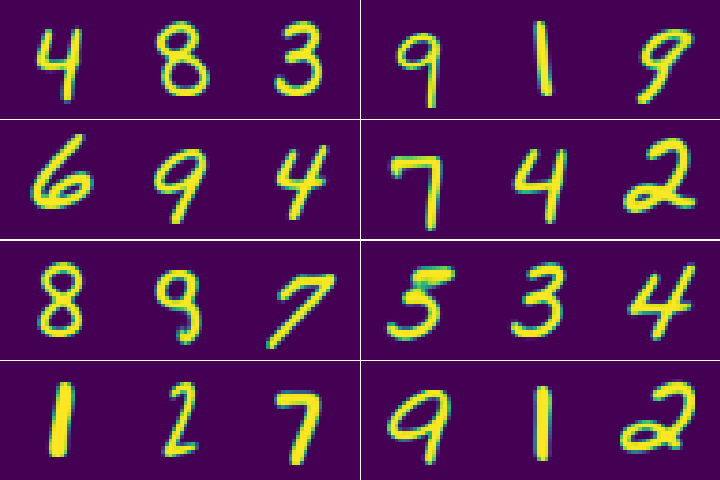

In [34]:
util.plot_imgs(D(lat));
# util.plot_imgs(D(E(D(lat))));

In [35]:
lat.shape

torch.Size([24, 3])

In [36]:
def interpolate(x,y,n=10):
    delta = torch.linspace(0,1,n).view(1,n,1).to(x.device)
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    return delta*y + (1-delta)*x

In [37]:
sel = np.arange(len(lat))[:4]
nsteps = 10
trav = interpolate(lat[sel], lat[(sel+1)%len(lat)], nsteps)
trav.shape

torch.Size([4, 10, 3])

<IPython.core.display.Javascript object>


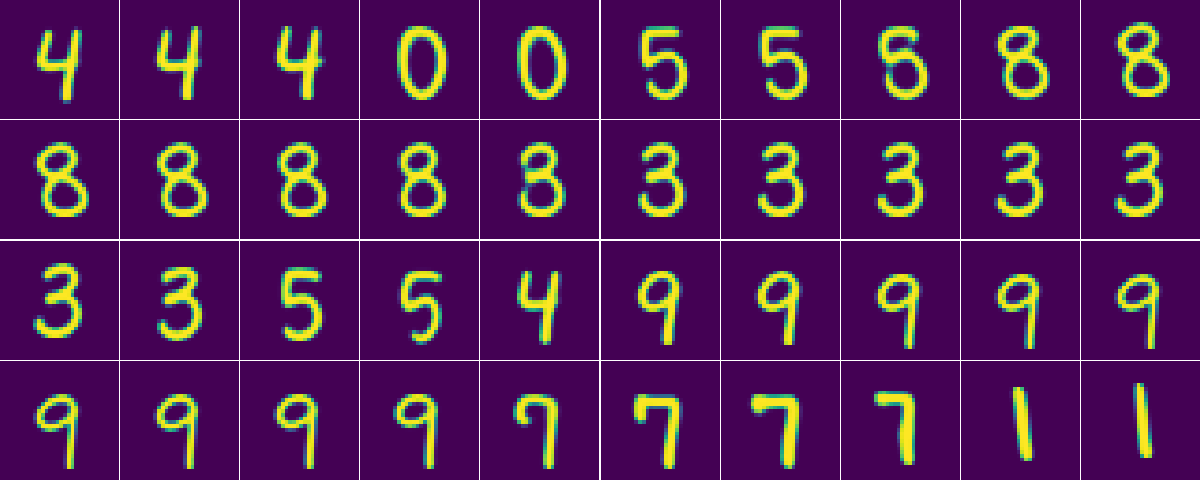

In [38]:
util.plot_imgs(D(util.combine_dims(trav,0,2).contiguous()), W=nsteps);

In [39]:
niter = 8
qs = [lat]
rs = []

In [40]:
for _ in tqdm(range(niter)):
    rs.append(D(qs[-1]))
    qs.append(E(rs[-1]))
rs = torch.stack(rs)
qs = torch.stack(qs)
qs.shape, rs.shape

/tmp/ipykernel_20530/2183506975.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(niter)):


  0%|          | 0/8 [00:00<?, ?it/s]

(torch.Size([9, 24, 3]), torch.Size([8, 24, 1, 32, 32]))

<IPython.core.display.Javascript object>


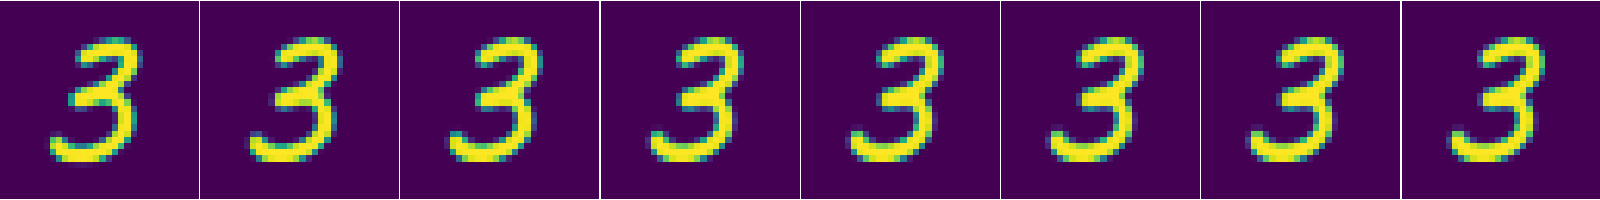

In [41]:
util.plot_imgs(rs[:,np.random.randint(rs.shape[1])], W=niter);

In [42]:
# util.plot_imgs(rs[0]);

In [43]:
# util.plot_imgs(rs[-1]);

In [44]:
fullQ = []
total = 10000 if dname in {'mnist', 'cifar10'} else 256
bs = 1000 if dname in {'mnist', 'cifar10'} else 8
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    x = next(loader)[0]
    fullQ.append(E(x))
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
dout = fullQ.size(-1)
fullQ.shape

/tmp/ipykernel_20530/243736467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=total)


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 3])

In [45]:
Q = lat.clone()
Q.shape

torch.Size([24, 3])

In [58]:
dims = 0,1
# dims = 1,2
# dims = 0,2
# dims = 43, 44
# dims = 35, 37
# dims = 45, 53
# dims = 36, 52
# dims = 29, 53
# dims = 137, 135

ix, iy = dims
dims

(0, 1)

<IPython.core.display.Javascript object>


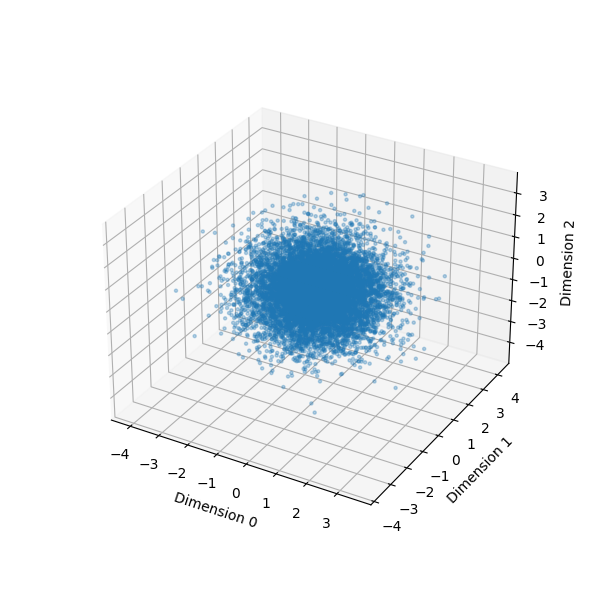

In [59]:
stretch = .1

dims3d = (0,1,2)
# dims3d = (*dims, 29)

pts = torch.randn(*fullQ.shape)
# pts = fullQ.clone()
pts_steps = [pts]


original_pts = pts.clone()

mn, mx = pts.min(0)[0], pts.max(0)[0]
rg = mx-mn
mn, mx = mn-stretch*rg, mx+stretch*rg

def _plt_pts(pts, cs='C0', fsize=6, **kwargs):
    fg = plt.figure(figsize=(fsize,fsize))
    ax = fg.add_subplot(111, projection='3d');

    ax.scatter(*pts[:,dims3d].t().numpy(), marker='.', alpha=0.3, c=cs, **kwargs)
    ax.set_xlabel(f'Dimension {dims3d[0]}')
    ax.set_ylabel(f'Dimension {dims3d[1]}')
    ax.set_zlabel(f'Dimension {dims3d[2]}');

# plt.figure(figsize=(8,8))
# plt.title('Posterior')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# # plt.xlim(mn[0], mx[0])
# # plt.ylim(mn[1], mx[1])
# hist, *other = np.histogram2d(*pts.t().cpu().numpy(), bins=nside, normed=True, range=torch.stack([mn[list(dims)], mx[list(dims)]]).t().cpu().numpy())
# plt.imshow(hist.T[::-1], cmap='Blues', interpolation='spline36',
#            extent=[mn[0].item(), mx[0].item(),mn[1].item(), mx[1].item()], aspect=aspect_ratio);

_plt_pts(pts)

In [60]:
for i in range(8):
    newpts = []
    for v, in tqdm(DataLoader(TensorDataset(pts), batch_size=bs), desc=f'Cycling {len(pts)} samples'):
        with torch.no_grad():
            newpts.append(R(v))
    pts = torch.cat(newpts)
    pts_steps.append(pts)
# del newpts
PTS = torch.stack(pts_steps)
PTS.shape

/tmp/ipykernel_7185/311462356.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(pts), batch_size=bs), desc=f'Cycling {len(pts)} samples'):


Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([9, 10000, 3])

In [95]:
# _plt_pts(pts,fsize=12);
# plt.title(f'Step {len(pts_steps)-1}');

In [62]:
k = 8
pts = PTS[k]

In [63]:
from sklearn import cluster
# cmdl = cluster.AgglomerativeClustering(
#     n_clusters=None, 
#     distance_threshold=0.1, 
#     linkage='single')
# cmdl = cluster.Birch(threshold=0.8, branching_factor=20, n_clusters=None)
# cmdl = cluster.KMeans(n_clusters=20, random_state=0)
# cmdl = cluster.DBSCAN(eps=0.1, min_samples=10)
cmdl = cluster.DBSCAN(eps=0.12, min_samples=4)
# cmdl = cluster.OPTICS(
# #     min_samples=10, 
#     min_samples=50, 
# #     min_cluster_size=0.02, 
# #     metric='l2', 
# #     cluster_method='dbscan', 
#     max_eps=5,
# #     xi=0.01,
# )
clts = torch.from_numpy(cmdl.fit(pts.numpy()).labels_)
clts.max()+1, (clts>0).sum()/len(clts)*100

(tensor(52), tensor(86.3800))

<IPython.core.display.Javascript object>


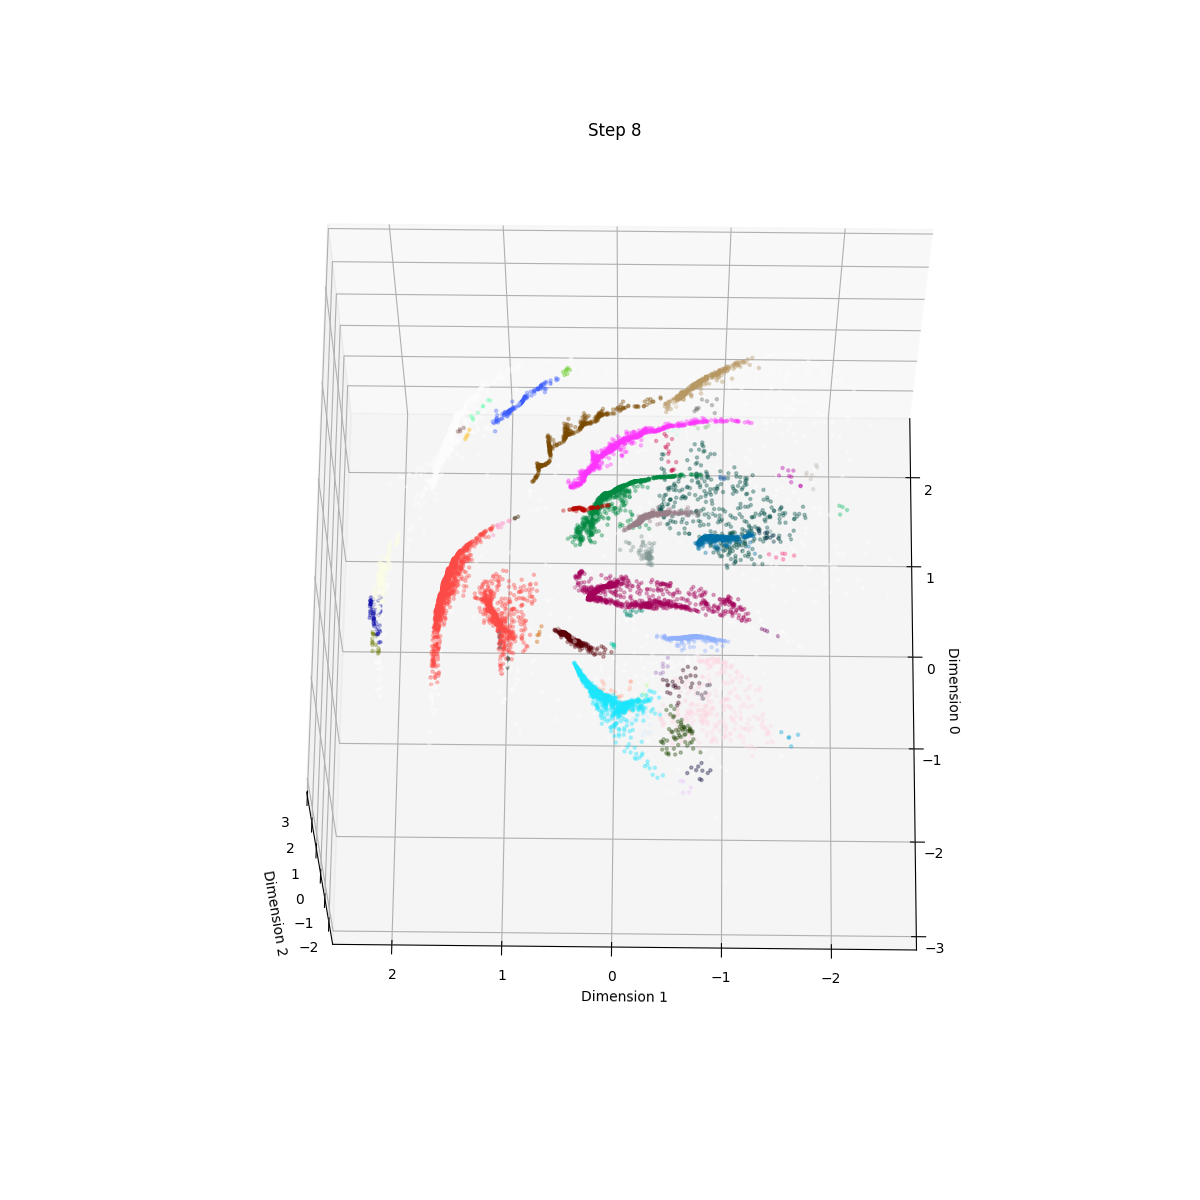

In [64]:

_plt_pts(pts, cs=[distinct_colors[(c%(len(distinct_colors)-1))+1] if c > 0 else 'w' for c in clts], fsize=12);
# _plt_pts(pts[torch.from_numpy(clts)>0], cs=[distinct_colors[c+1] if c > 0 else 'w' for c in clts if c > 0], fsize=12);
plt.title(f'Step {k}');
# plt.savefig(str(imgroot/f'clusters-step{k}.png'));

In [97]:
_plt_pts(pts,fsize=12);
plt.title(f'Step {len(pts_steps)-1}');
plt.title(f'Step {k}');
# plt.savefig(str(imgroot/f'pts-step{k}.png'));

In [136]:
# _plt_pts(original_pts, cs=[distinct_colors[(c%(len(distinct_colors)-1))+1] if c > 0 else 'w' for c in clts], fsize=12);

In [86]:
cnts = torch.bincount(clts[clts>0])
order = cnts.sort(0,descending=True)[1]

In [87]:
nums = cnts[order].float()
nums[1:-1].div(nums[:-2]).min(0)
cnts[order][:50]

tensor([1645, 1009,  869,  770,  708,  537,  487,  357,  339,  335,  293,  269,  226,  143,  130,   69,   61,   61,   51,   28,   27,   24,   16,   15,   14,   10,   10,    9,    9,    9,    8,    7,    7,    7,    7,    7,    6,    5,    5,    5,    5,    5,    4,    4,    4,    4,    4,    4,
           4,    3])

In [102]:
# qsel = original_pts[clts == order[1]]
# util.plot_imgs(D(qsel[torch.randperm(qsel.size(0))[:20]]));

In [98]:
# topk = 20
# egs = 8
# imgs = []
# for o in order[:topk]:
#     qsel = pts[clts == o]
# #     qsel = original_pts[clts == o]
#     imgs.append(D(qsel[torch.randperm(qsel.size(0))[:egs]]))
# print(cnts[order[:topk]]/len(pts)*100)
# fg, axs = util.plot_imgs(torch.cat(imgs), H=topk, W=egs);
# len(axs)

In [137]:
# plt.savefig(str(imgroot/f'cluster-samples.png'));

In [132]:
axs = np.array(axs).reshape(topk,egs)
axs.shape

(20, 8)

In [133]:
for axrow, p in zip(axs, (cnts[order[:topk]]/len(pts)*100).tolist()):
    for a in axrow:
        plt.sca(a)
        plt.axis('on')
        plt.xticks([],[])
        plt.yticks([],[])
    plt.sca(axrow[0])
    plt.ylabel(f'{p:2.1f}%')

In [134]:
plt.subplots_adjust(left=0.05);
# plt.subplots_adjust(wspace=between, hspace=between, left=border, right=1 - border, bottom=border, top=1 - border)

In [135]:
(cnts[order[:topk]]/len(pts)*100).sum()

tensor(85.6400)

In [65]:
PTS.shape

torch.Size([9, 10000, 3])

In [66]:
motion = PTS[1:] - PTS[:-1]

In [74]:
motion.shape

torch.Size([8, 10000, 3])

In [73]:
# 10000000 ** (1/64)

In [75]:
motion.norm(2, -1).mean(-1)

tensor([0.1835, 0.1272, 0.1008, 0.0848, 0.0740, 0.0659, 0.0599, 0.0544])

In [78]:
motion.mean(1).norm(2,-1)

tensor([0.0742, 0.0602, 0.0488, 0.0407, 0.0342, 0.0293, 0.0258, 0.0231])

In [115]:
# from sklearn import manifold
# import umap

In [204]:
# # embedding = manifold.Isomap(n_neighbors=10, n_components=2)
# # embedding = manifold.TSNE(n_components=2)
# embedding = umap.UMAP(n_neighbors=20)
# psel = pts[clts == order[1]]
# psel = pts
# pts_t = torch.as_tensor(embedding.fit_transform(psel.numpy()))

In [202]:
# cl = psel[:,1]
# cl = (cl-cl.min()) / (cl.max()-cl.min())
# cl.min(), cl.max()
# _plt_pts(psel,cl.numpy().tolist(), cmap='viridis',fsize=6);

In [203]:
# plt.figure()
# plt.scatter(*pts_t.t().numpy(), c=cl.numpy().tolist(), cmap='viridis');

In [195]:
# xpts = torch.randn(50, 2)*3 + torch.as_tensor([2.,6])
# xpts = torch.linspace(0,1,50).float().view(-1, 1)
# xs, xe = torch.as_tensor([11.5, 5.4]), torch.as_tensor([-5.3, 7])
# xpts = (1-xpts)*xs.view(1,-1) + xpts*xe.view(1,-1)

In [196]:
plt.figure(24)
# plt.scatter(*xpts.t().numpy(), marker='x');

plt.plot(*xpts.t().numpy());

In [197]:
vpts = torch.as_tensor(embedding.inverse_transform(xpts.numpy()))
vpts.shape

torch.Size([50, 3])

In [198]:
plt.figure(23)
# plt.gca().scatter(*vpts.t().numpy(), marker='x');
plt.gca().plot(*vpts.t().numpy());

<Axes3DSubplot:xlabel='Dimension 0', ylabel='Dimension 1'>

In [138]:
# Qsel = Q[:,dims]
# pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# # plt.figure()
# # plt.scatter(*pts.t(), marker='.', c='k');
# U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
# S = S.sqrt()
# print('S',S)
# print(U)
# Q.shape, Qsel.shape

In [40]:
rg = 5

# mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
# mn, mx = mn.view(-1), mx.view(-1)

# print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(din)*-rg, torch.ones(din)*rg

In [52]:
bidx = 9
bidx = 0
# qbase = Q[bidx]

other_dims = [i for i in range(din) if i not in dims]

qbase = torch.randn(din)

z0 = 0.
# qbase[other_dims] = z0

qbase

tensor([-2.9637,  1.2219, -0.0194,  0.8626,  1.0058, -0.5796, -0.0384, -0.8980, -1.0339,  0.4709,  0.4062, -1.0286,  1.9107, -0.5980,  0.3731,  0.8042,  0.2069, -0.1344, -1.8770,  0.3348,  1.2482, -1.2331,  0.5225, -1.4107,  0.5531, -0.8976, -1.5789,  0.8249,  0.2268, -0.3389,  1.4184,  0.1738,
         0.4787,  2.5624,  0.3396,  1.2196, -0.6284, -0.9367, -0.6014,  0.5247,  0.6319,  0.8459,  0.0614,  0.2140,  0.4531,  2.2574, -0.1887,  0.1134,  1.2274,  1.3435, -0.1187, -0.8319,  0.8681,  0.2197,  1.3068, -0.5222,  1.4603,  2.0166, -1.2466, -0.3952, -1.2013,  1.0280,  0.6768, -1.3002])

In [53]:
n = 32
nside = n
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = qbase.unsqueeze(0).expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([1024, 64])

In [54]:
starts = vecs[...,dims]
ends = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Cycling {len(vecs)} samples'):
    with torch.no_grad():
        ends.append(R(v)[...,dims])
starts = starts.view(h,w,2)
ends = torch.cat(ends).view(h,w,2)
dels = ends.sub(starts)
delmap = dels.permute(1,0,2).numpy()[::-1]
ends.shape

/tmp/ipykernel_3998/2200089322.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Cycling {len(vecs)} samples'):


Cycling 1024 samples:   0%|          | 0/128 [00:00<?, ?it/s]

torch.Size([32, 32, 2])

In [55]:
# # dmap = torch.cdist(starts, Qsel).min(-1)[0].view(n,n)
# dmap = torch.cdist(starts, cts).min(-1)[0].view(n,n)
# # dmap = torch.cdist(starts, Qsel).mean(-1).view(n,n)
# distmap = dmap.numpy()
# dmap = dmap.t().numpy()[::-1]

mags = dels.pow(2).sum(-1)
costmap = mags.numpy()
mags = mags.t().numpy()[::-1]
# mags = deltas.view(h,w,2)[...,0]

normdels = dels.div(dels.norm(dim=-1,keepdim=True))
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)
divM = get_divergence(dels)
ndivM = get_divergence(normdels)

happymap = divM<0
happy = happymap.t().numpy()[::-1]
# landscape = divM - divM.min()
# divM -= divM.min()
divergence = divM
divM = divM.t().numpy()[::-1]
posterior_logits = ndivM.mul(-1)
ndivM = posterior_logits.t().numpy()[::-1]

divMprop = torch.from_numpy(divM.copy()).clone()
divMprop[divMprop>0] /= divMprop[divMprop>0].max().abs()
divMprop[divMprop<0] /= divMprop[divMprop<0].min().abs()
divMprop = divMprop.numpy()

ndivMprop = torch.from_numpy(ndivM.copy()).clone()
ndivMprop[divMprop>0] /= ndivMprop[divMprop>0].max().abs()
ndivMprop[divMprop<0] /= ndivMprop[divMprop<0].min().abs()
ndivMprop = ndivMprop.numpy()


# fmag = mags + dmap
# spacemap = distmap + costmap

fmag = mags
spacemap = costmap

In [56]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(0.9954), tensor(0.7299), tensor(0.7333))

In [57]:
n = 10
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = qbase.unsqueeze(0).expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy

emb = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Decoding {len(vecs)} samples'):
    with torch.no_grad():
        emb.append(D(v))
emb = torch.cat(emb)
C, H, W = emb.shape[-3:]
emb = util.split_dim(emb, h,w)
emb = torch.from_numpy(emb.numpy()[:,::-1].copy()).contiguous()
emb = emb.permute(2,1,3,0,4).reshape(C, h*H, w*W)
# imshape = imgs.shape[-3:]
# imgs = torch.from_numpy(util.split_dim(imgs, h,w).numpy()[:,::-1].copy()).contiguous().permute(1,0,2,3,4).contiguous()
# imgs = util.combine_dims(imgs, 0,2)
emb.shape

/tmp/ipykernel_3998/2633775350.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Decoding {len(vecs)} samples'):


Decoding 100 samples:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([3, 640, 640])

In [58]:
threshold = 0.1

pts = fullQ.clone()#[:,dims]

ext = pts[:,other_dims]
valid = (threshold >= ext).mul(-threshold<=ext).prod(-1)
valid[:] = 1
pts = pts[valid.bool()]
pts = pts[:,dims]
len(pts) / len(valid)

1.0

<IPython.core.display.Javascript object>


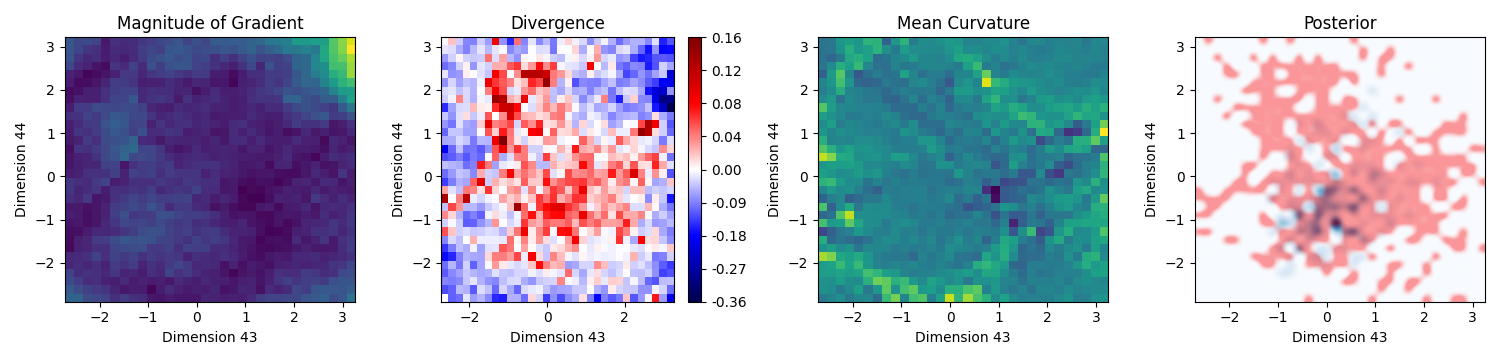

<IPython.core.display.Javascript object>


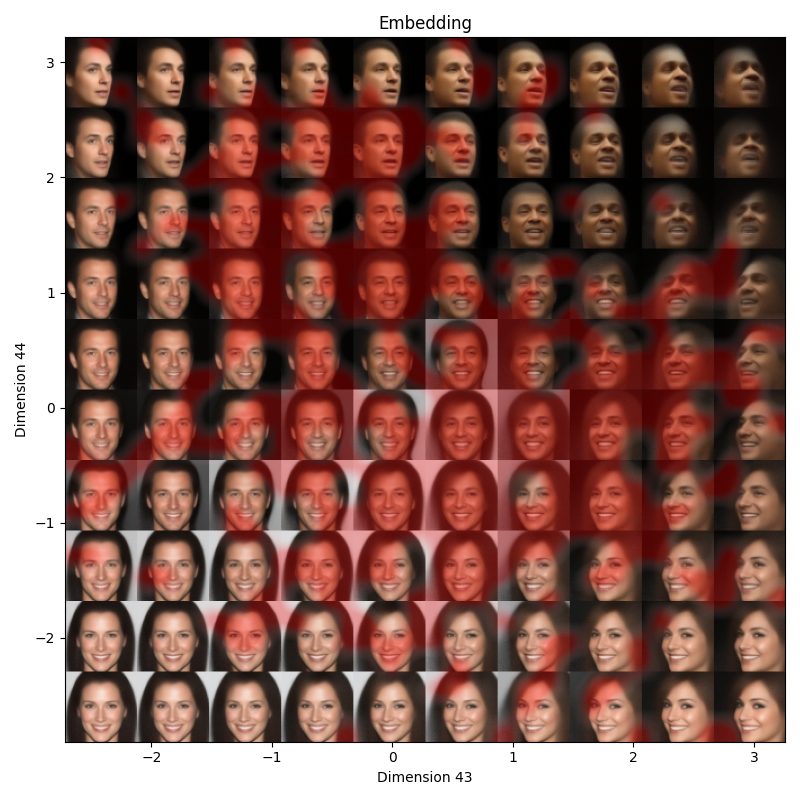

In [59]:
im = fmag
im = divM
# im = happy

# plt.figure()
# # plt.title('Map')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(im, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
# plt.tight_layout()

aspect_ratio = 'auto'
# aspect_ratio = 1

fg, axs = plt.subplots(1,4, figsize=(15,3.6))

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(mags**0.5, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[1])
# plt.title('Distance Mags')
# plt.imshow(dmap, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(ndivMprop, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[3])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*pts.t().cpu().numpy(), bins=nside, normed=True, range=torch.stack([mn[list(dims)], mx[list(dims)]]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Blues',interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
badsel = np.ones((*happy.shape,4))
badsel[...,-1] = 0.
badsel[~happy] = [1,0,0,1]
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8,
           alpha=0.4,interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags);
plt.tight_layout();

plt.figure(figsize=(8,8))
plt.imshow(emb.permute(1,2,0),  extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8,
           alpha=0.3,interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)

plt.title('Embedding')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.tight_layout();

In [85]:
# plt.figure(13)

In [168]:
# plt.savefig(str(imgroot/f'{dname}-{dims[0]}-{dims[1]}.png'));

In [60]:
def response_mat(Q, encode, decode, n_interv=None, scales=None,
                 force_different=False,
                 max_batch_size=None, device=None, pbar=None):
    if scales is not None:
        raise NotImplementedError

    @torch.no_grad()
    def response_function(q):
        if device is not None:
            q = q.to(device)
        r = encode(decode(q))
        if isinstance(r, distrib.Normal):
            r = r.loc
        return r

    B, D = Q.shape

    if n_interv is None:
        n_interv = B
    if max_batch_size is None:
        max_batch_size = n_interv

    itr = enumerate(Q.t())
    if pbar is not None:
        itr = pbar(itr, total=D)
        
    resps = []
    for i, qi in itr:  # Opy(D) (n_interv is parallelized)
        order = torch.randperm(B)
        iorder = order.clone()
        if force_different:
            iorder[1:] = order[:-1]
            iorder[0] = order[-1]
        qsel = slice(0,n_interv) if force_different else torch.randint(B, size=(n_interv,))
        isel = slice(0,n_interv) if force_different else torch.randint(B, size=(n_interv,))
        q = Q[order[qsel]]
        dq = q.clone()
        dq[:, i] = qi[iorder[isel]]
        z = util.process_in_batches(response_function, q, batch_size=max_batch_size)
        dz = util.process_in_batches(response_function, dq, batch_size=max_batch_size)
        resps.append(dz.sub(z).pow(2).mean(0).sqrt())
    return torch.stack(resps)

In [61]:
rmat = response_mat(fullQ, E, D, n_interv=50, max_batch_size=bs, pbar=tqdm)
rmat.shape

/tmp/ipykernel_25396/1498418551.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  itr = pbar(itr, total=D)


  0%|          | 0/256 [00:00<?, ?it/s]

torch.Size([256, 256])

<IPython.core.display.Javascript object>


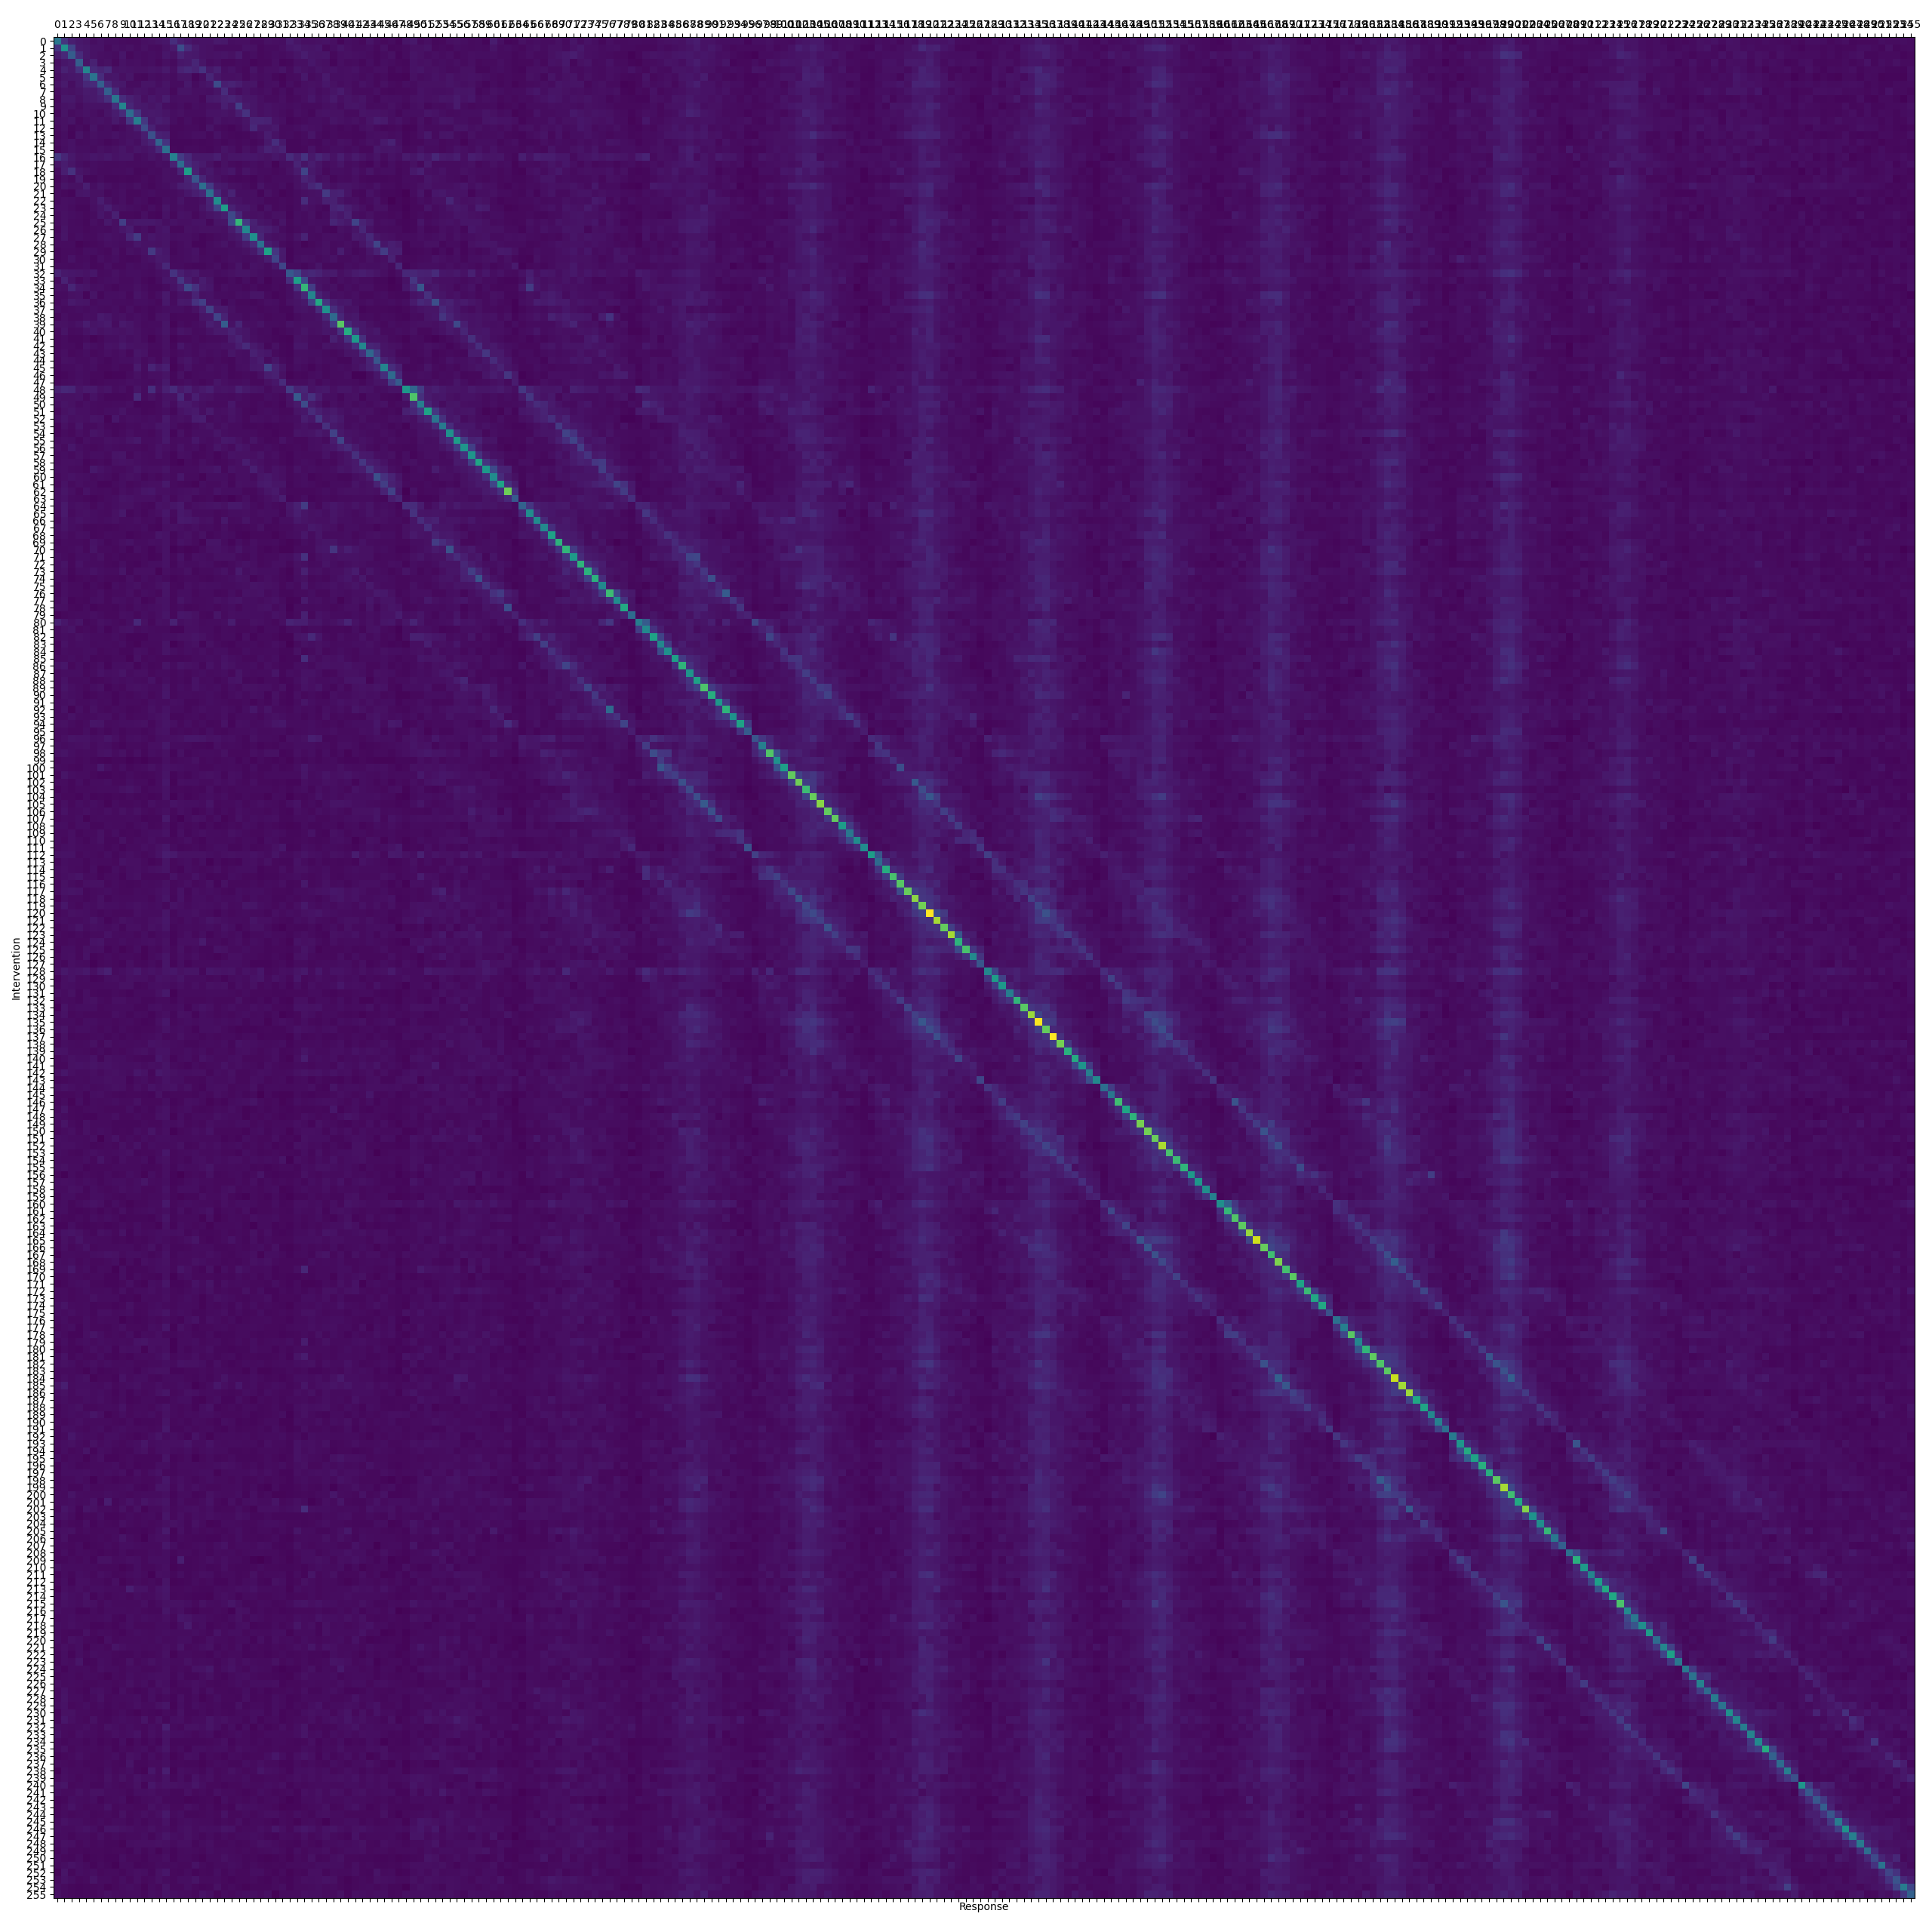

In [63]:
# threshold = 0.5
# threshold_2d = 0.1

sel = torch.arange(len(rmat))
# sel = torch.arange(len(rmat))[rmat.diag() > threshold]
# bsel = torch.arange(len(rmat))[rmat.diag() <= threshold]
# sel, bsel
# rsel = rmat.clone()
rsel = rmat[sel][:,sel]
hside = 0.1
util.plot_mat(rsel, #val_fmt='.1f',
              figsize=(len(rsel)*hside, hside*len(rsel))
             ) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout();
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

<IPython.core.display.Javascript object>


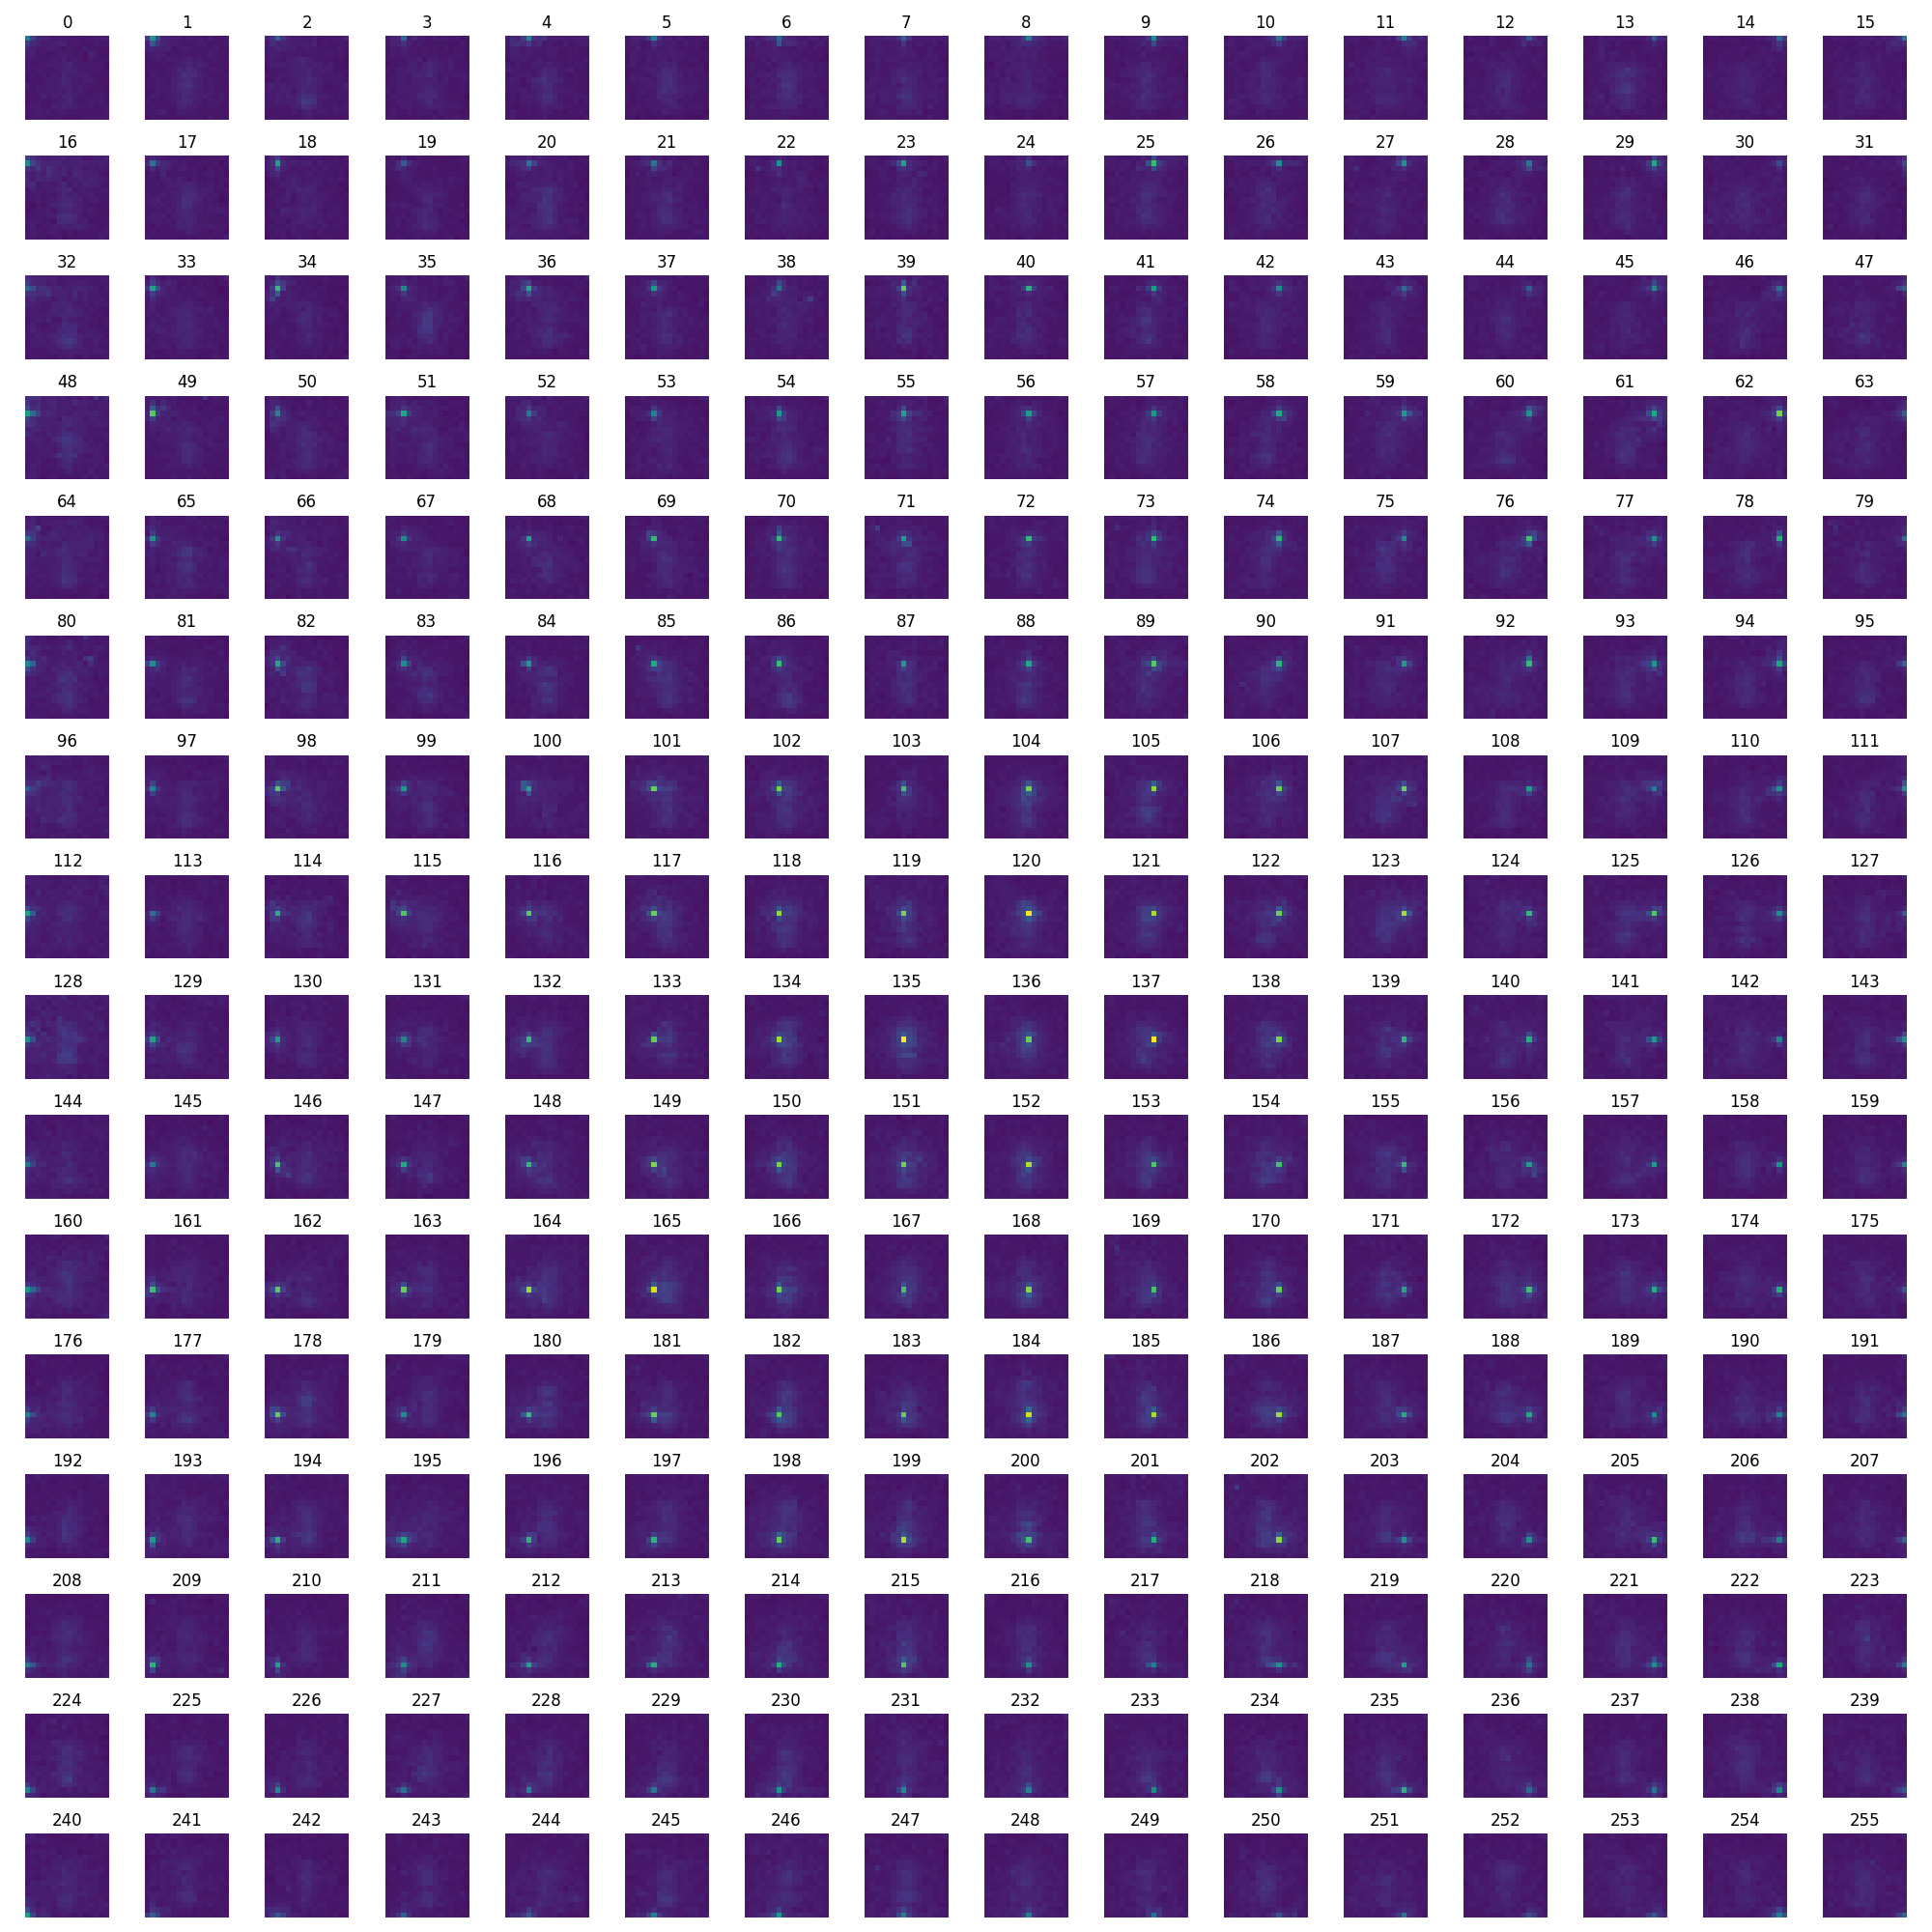

In [66]:
sr = rmat.clone().view(-1, *_shape[1:])
util.plot_imgs(sr.unsqueeze(1), titles=[str(i) for i in range(len(sr))], figsize=(20,20), params={'vmax': 1, 'vmin': 0}, between=0);

In [72]:
tpk = 10
dvals, dinds = rmat.diag().sort(0,descending=True)
print(dvals[:tpk])
print(dinds[:tpk])

tensor([1.0080, 1.0077, 0.9977, 0.9389, 0.9262, 0.8861, 0.8764, 0.8752, 0.8747, 0.8718])
tensor([137, 120, 135, 165, 184, 152, 123, 199, 121, 185])


In [238]:
qbase = torch.randn(din)

<IPython.core.display.Javascript object>


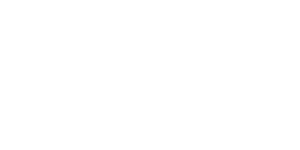

In [244]:
# idx = 21, 29, 37, 45 # -> gender, beard, skin tone
idx = 37
# idx = 45 # +/- => male/female
# idx = 53

nsteps = 40
rg = 6
qs = qbase.unsqueeze(0).expand(nsteps, -1).clone()
qs[:,idx] = torch.linspace(-rg, rg, steps=nsteps)
vid = util.Video(D(qs).permute(0,2,3,1))
vid.play('jupyter', scale=4)

/tmp/ipykernel_8216/2131682052.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(qs), batch_size=32), desc=f'Decoding {len(qs)} samples'):


Decoding 100 samples:   0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


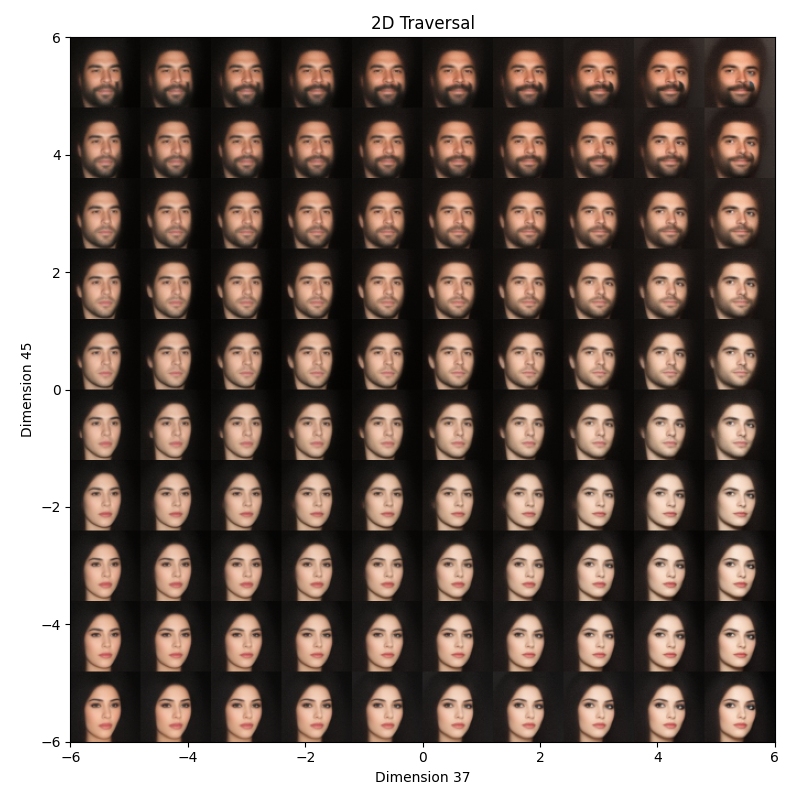

In [245]:
inds = 35, 37
inds = 6, 45
# inds = 45, 43 # 44
inds = 29, 53
inds = 52, 53
inds = 37, 45
# inds = 51, 52
# inds = 36, 52

nsteps = 10
rg = 6
h, w = nsteps, nsteps

xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

qs = qbase.unsqueeze(0).expand(len(cx), -1).contiguous()
qs[:, inds[0]] = cx
qs[:, inds[1]] = cy

trav = []
for v, in tqdm(DataLoader(TensorDataset(qs), batch_size=32), desc=f'Decoding {len(qs)} samples'):
    with torch.no_grad():
        trav.append(D(v))
trav = torch.cat(trav)
C, H, W = trav.shape[-3:]
trav = util.split_dim(trav, h,w)
trav = torch.from_numpy(trav.numpy()[:,::-1].copy()).contiguous()
trav = trav.permute(2,1,3,0,4).reshape(C, h*H, w*W)
trav.shape

plt.figure(figsize=(8,8))
plt.imshow(trav.permute(1,2,0), extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
plt.title('2D Traversal')
plt.xlabel(f'Dimension {inds[0]}')
plt.ylabel(f'Dimension {inds[1]}')
plt.tight_layout();

In [54]:
def even_samples(N, *shape):
    samples = []
    total = 0.
    for _ in range(N):
        samples.append(torch.randn(*shape) - total)
        total += samples[-1]
    return torch.stack(samples)
def normalize(x):
    N, *shape = x.shape
    mag = x.view(N,-1).norm(2,-1).view(N, *([1]*(len(x.shape)-1)))
    return x.div(mag)

<IPython.core.display.Javascript object>


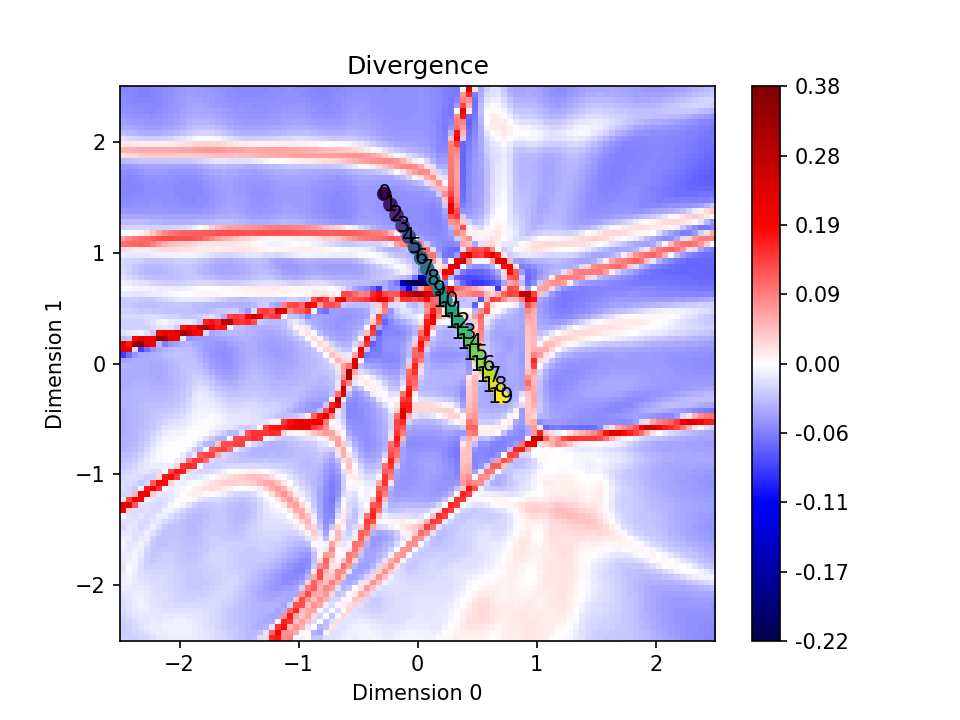

<IPython.core.display.Javascript object>


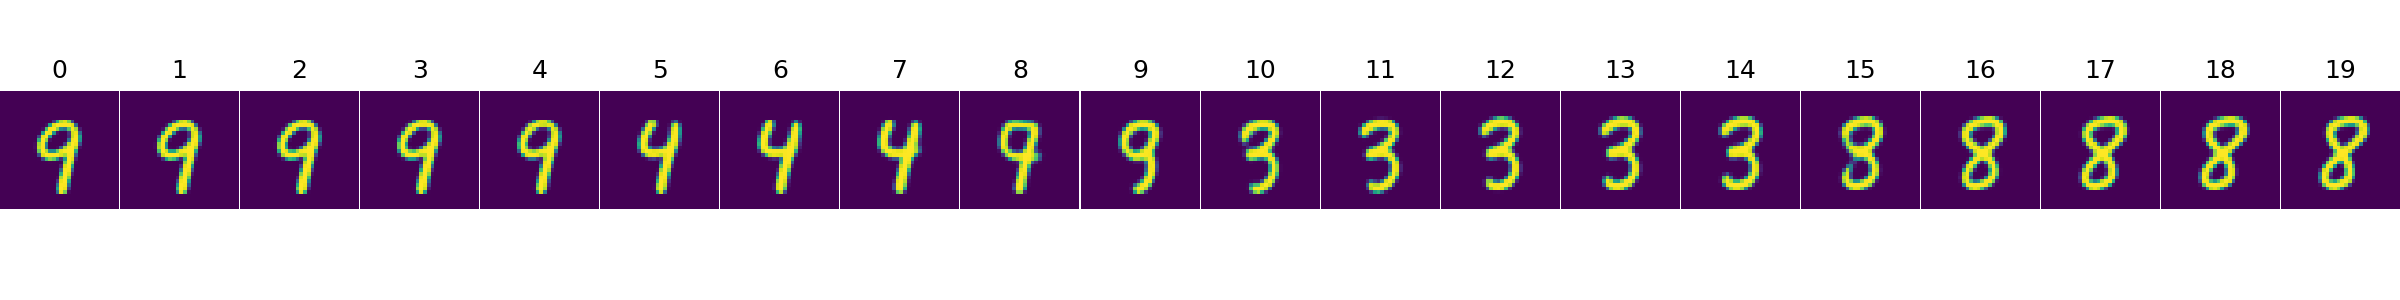

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


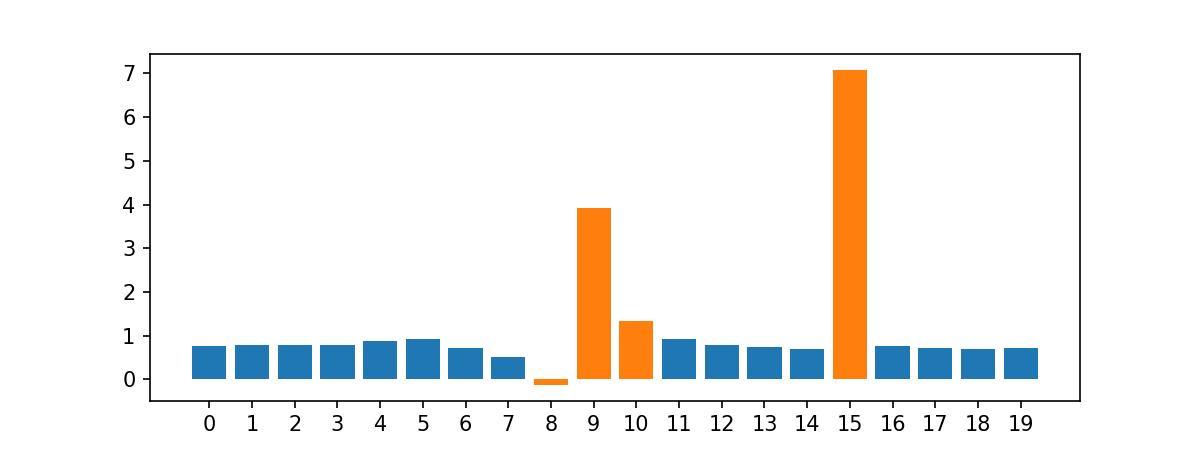

In [70]:
nsteps = 20
qp = torch.randn(2,din)
qp[0,:2] = torch.as_tensor([-0.28, 1.53])
qp[1,:2] = torch.as_tensor([0.7, -0.3])
qp[:,-1] = z0
qinp = interpolate(qp[[0]], qp[[1]], nsteps)[0]
qinp.shape, qp

plt.figure()
ax = plt.gca()
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}');

qi = qinp[:,dims]
plt.scatter(*qi.t(), c=torch.linspace(0,1,len(qi)))

xinp = D(qinp)
fg, axs = util.plot_imgs(xinp, W=nsteps)

plt.sca(ax)
for i, (x,y) in enumerate(qi):
    plt.text(x.item(),y.item(), s=str(i), ha='center', va='center')
for i, ax in enumerate(axs):
    plt.sca(ax)
    plt.title(str(i))

dm = din

b = 10
scale = 0.001

# eps = torch.randn(b+1, dm)
eps = even_samples(b+1, dm)
eps = normalize(eps)
eps *=  scale
eps[0] *= 0

# base = qp.clone()
base = qinp.clone()
samples = base.unsqueeze(0) + eps.unsqueeze(1)
resp = util.process_in_batches(R, samples.view(-1, dm), batch_size=128, pbar=tqdm).view(*samples.shape)
rp = resp[1:] - resp[:1]
deltas = eps[1:].unsqueeze(1) / scale**2
out = rp @ deltas.permute(0,2,1)
# out = rp.sum(-1) / scale
dv = out.mean(0).squeeze(-1) 
# dv = out.max(0)[0].squeeze(-1) 

plt.figure(figsize=(8,3))
plt.bar(np.arange(len(dv)),dv, color=[f'C{int(0>v or v>1)}' for v in dv])
plt.xticks(np.arange(len(dv)), map(str, np.arange(len(dv))));

In [59]:
# shape = 10,10
# N = 50
# r = torch.randn(N,*shape)
# x = even_samples(N, *shape)
# r = normalize(r)
# x = normalize(x)
# # fg, (ax1, ax2) = plt.subplots(2)
# # plt.sca(ax1)
# # plt.scatter(*x.t())
# # plt.sca(ax2)
# # plt.scatter(*r.t())
# print(x.mean(0).view(-1).norm(2), r.mean(0).view(-1).norm(2))

# Full Latent Space

<IPython.core.display.Javascript object>


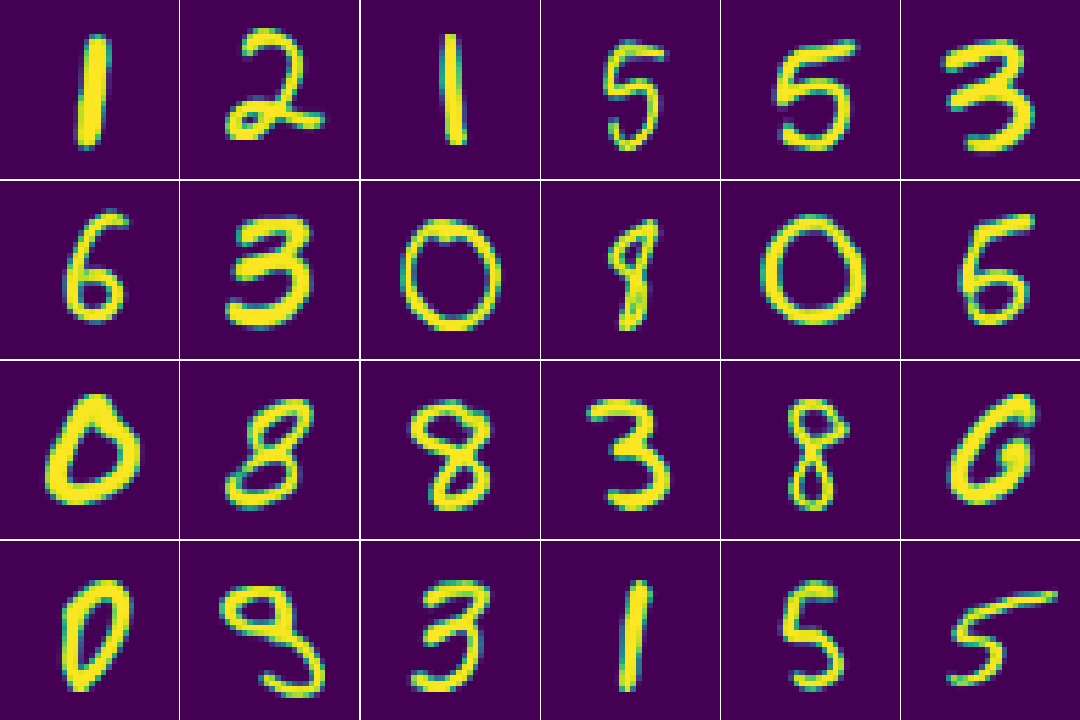

In [312]:
inits = to_img(model.sample(24, t=0.6))
util.plot_imgs(inits);

c:\users\anwan\onedrive\khan\research\foundation\omnilearn\util\viz.py:349: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fg, axes = plt.subplots(H, W, figsize=figsize)


<IPython.core.display.Javascript object>


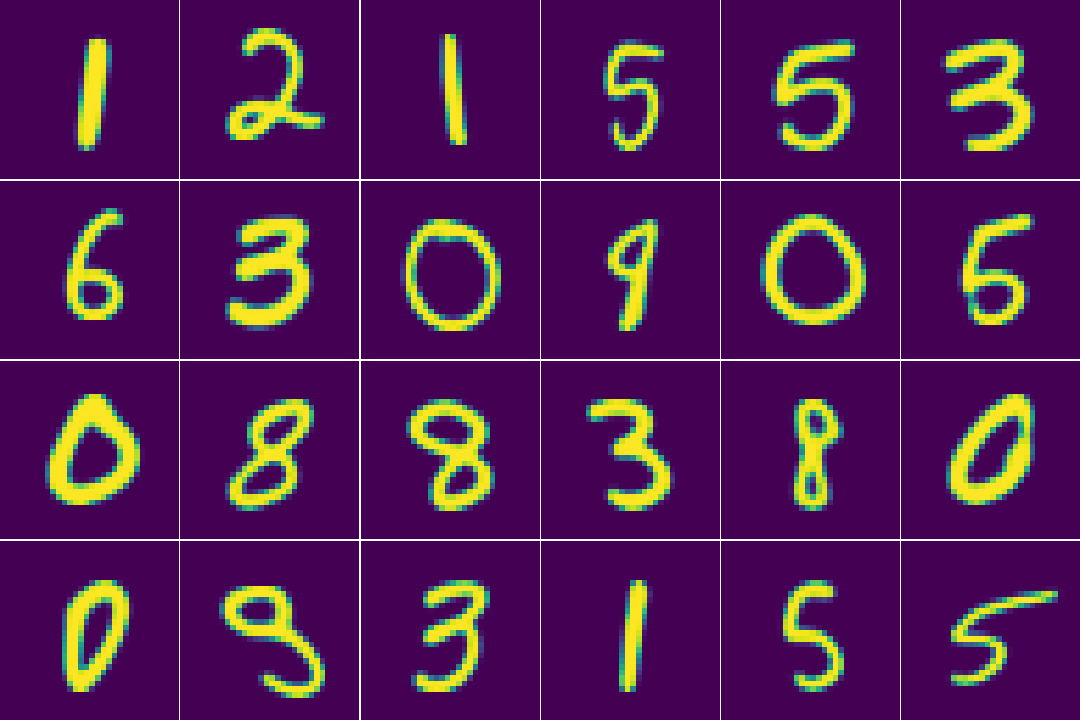

In [374]:
lats = encode(inits, t=0.1)
rec = to_img(decode(lats))
util.plot_imgs(rec);

In [375]:
from torch.utils.data import DataLoader, TensorDataset

In [378]:
bnum = 10

samples = [torch.cat([lat.sample()[0] for _ in range(bnum)]) for lat in lats]
base = [lat.mu for lat in lats]
len(samples), len(base)

bs = 64
niter = len(DataLoader(TensorDataset(samples[0]), batch_size=bs))
feed = [iter(DataLoader(TensorDataset(z), batch_size=bs)) for z in samples]
Rs = []
for z in tqdm(zip(*feed), total=niter):
#     break
    Rs.append([rdist.mu for rdist in encode(to_img(decode([_z[0] for _z in z])),t=0)])
Rs = [torch.cat(rzs) for rzs in zip(*Rs)]
Rb = [b.mu for b in encode(to_img(decode(base)),t=0)]

dvs = []

for s, b, rs, rb in zip(samples, base, Rs, Rb):
    N = b.shape[0]
    s = s.view(bnum, N, -1)
    rs = rs.view(bnum, N, -1)
    b = b.view(1, N, -1)
    rb = rb.view(1, N, -1)
    
    
    eps = s - b
    scale = eps.norm(2,-1,True)
    
    rp = rs - rb
    rp = rp / scale
    deltas = eps / scale
    out = rp.mul(deltas).sum(-1)
    # out = rp.sum(-1) / scale
    dv = out.mean(0).squeeze(-1).cpu()
    
    dvs.append(dv)

# len(Rs), len(Rb)

<ipython-input-378-411001c97774>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for z in tqdm(zip(*feed), total=niter):


  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


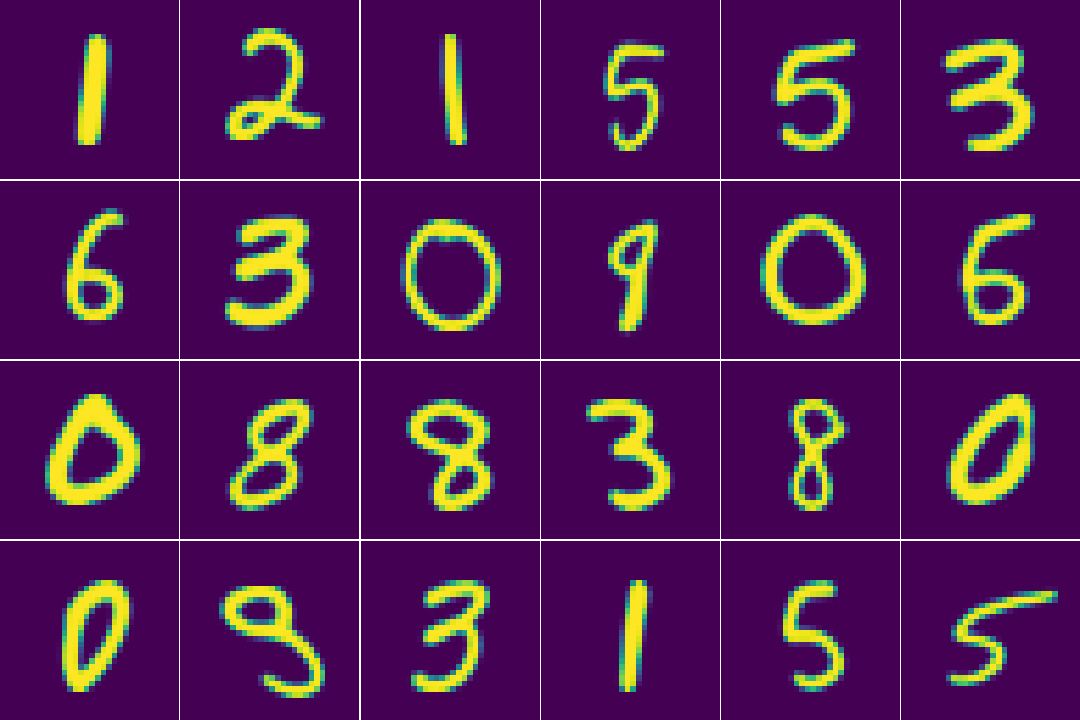

<IPython.core.display.Javascript object>


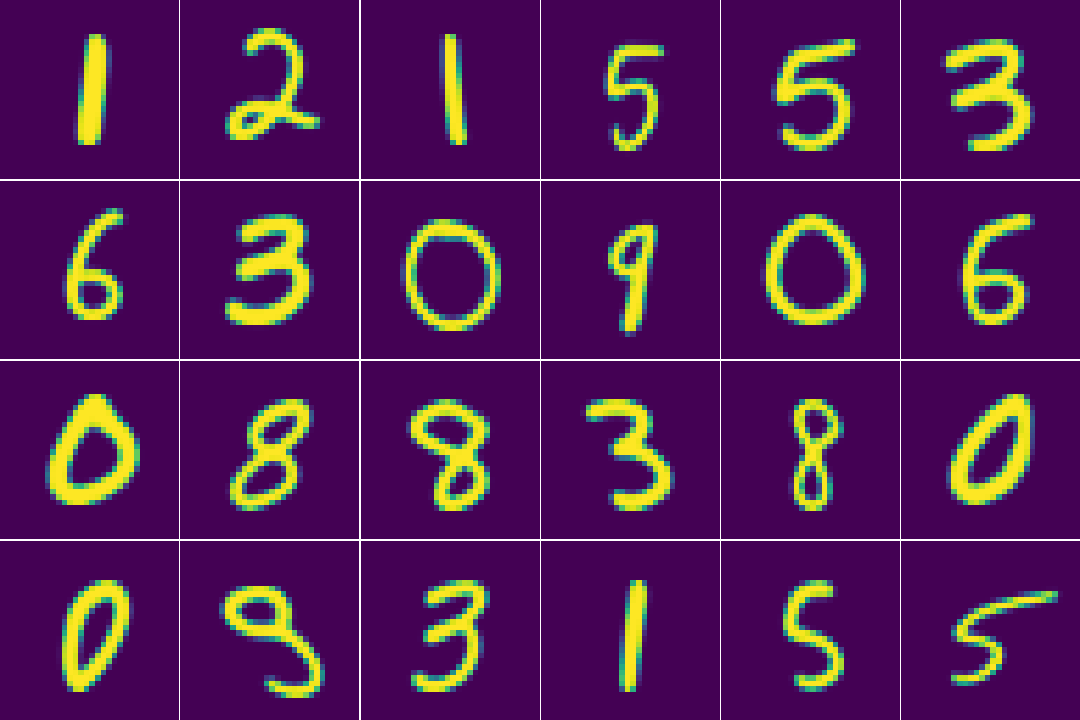

<ipython-input-379-5f59d65630cb>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,3))


<IPython.core.display.Javascript object>


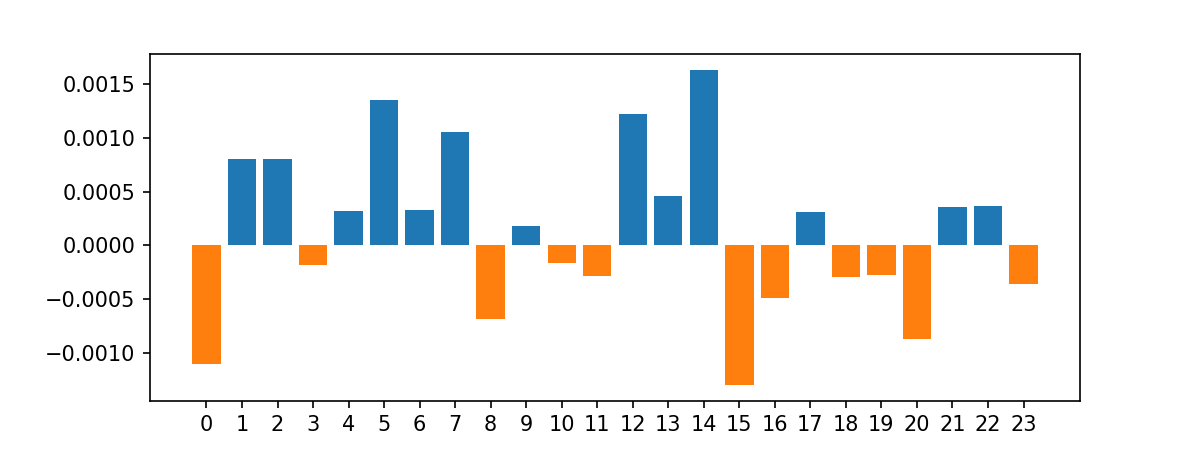

In [379]:
# util.plot_imgs(to_img(decode(Rs)));
util.plot_imgs(to_img(decode(base)));
util.plot_imgs(to_img(decode(Rb)));

dv = sum(dvs) / len(dvs)

plt.figure(figsize=(8,3))
plt.bar(np.arange(len(dv)),dv, color=[f'C{int(0>v or v>1)}' for v in dv])
plt.xticks(np.arange(len(dv)), map(str, np.arange(len(dv))));